<a href="https://colab.research.google.com/github/antimatter13-hue/GR_halo-simulation/blob/main/GR_yuan_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

->코드설명<-

이 코드는 머신러닝을 통해 전체 질량, 각운동량(?), 별 생성률의 변화에 따른 별 질량을 예측하는 코드입니다.

학습 및 테스트 예측용 데이터로 특정 스냅샷의 전체 데이터를 가져옵니다.

상관행렬을 통해 각 변수 간의 상관관계를 확인하고, 이를 바탕으로 x 변수를 결정하여 모델링을 진행하였습니다.

sequential?이라는 tensorflow 내장 모델을 활용해서 예측을 진행하네요.



###메모




In [ ]:
#totalmass = halodata[:, 0] # SubhaloMass (Msun)
#gasmass = halodata[:, 1] # SubhaloMassType[0,1,4,5] (Msun) 0: Gas, 1: DM, 4: Star, 5:BH
#dmmass = halodata[:, 2] #
#starmass = halodata[:, 3] #
#bhmasstemp = halodata[:, 4] #
#halopos = halodata[:, 5:8] # SubhaloPos (3D, kpc)
#halovel = halodata[:, 8:11] # SubhaloVel (3D, km/s)
#halospin = halodata[:, 11:14] # SubhaloSpin (3D, kpc*km/s)
#vmax = halodata[:, 14] # SubhaloVmax (km/s)
#vmaxRad = halodata[:, 15] # SubhaloVmaxRad (kpc)
#gasRhalf = halodata[:, 16] # SubhaloHalfmassRadType[0,1,4] (kpc)
#dmRhalf = halodata[:, 17]
#starRhalf = halodata[:, 18]
#starZ = halodata[:, 19] # SubhaloStarMetallicity
#gasZ = halodata[:, 20] # SubhaloGasMetallicity
#sfr = halodata[:, 21] # SubhaloSFR (Msun/yr)
#bhmass = halodata[:, 22] # SubhaloBHMass (Msun)

#del halodata

#halospin_A = (halospin[:,0]**2 + halospin[:,1]**2 + halospin[:,2]**2)**0.5

#df = pd.DataFrame(np.c_[totalmass, gasmass, dmmass, starmass, halospin_A, vmax, vmaxRad, dmRhalf, gasRhalf, starRhalf, gasZ, starZ, sfr, bhmass],
#                  columns=['TotalMass', 'GasMass', 'DMMass', 'StarMass', 'SpinAmp', 'Vmax', 'VmaxRad', 'DMRhalf', 'GasRhalf', 'StarRhalf', 'GasZ', 'StarZ', 'SFR', 'BHMass'])

##코드

In [ ]:
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

from scipy.interpolate import make_interp_spline

from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score

import os
from os.path import isfile, join
import sys
import gc

import zipfile
import pickle

import numba
import math


plt.rcParams['font.weight'] = 'normal'
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='stixgeneral'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.facecolor'] = 'white'

h = 0.6774


Msun=1.99e30 # kg
kpc=3.086e19 # m
G=6.67408e-11 # m^3 kg^-1 s^-2
c=3e10 # m s^-1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
h=0.6774


z_list=[20.05, 14.99, 11.98, 10.98, 10.00, 9.39, 9.00, 8.45, 8.01, 7.60, 7.24, 7.01, 6.49, 6.01, 5.85, 5.53, 5.23, 5.00, 4.66, 4.43, 4.18, 4.01, 3.71, 3.49, 3.28, 3.01, 2.90, 2.73, 2.58, 2.44,\
   2.32, 2.21, 2.10, 2.00, 1.90, 1.82, 1.74, 1.67, 1.60, 1.53, 1.50, 1.41, 1.36, 1.30, 1.25, 1.21, 1.15, 1.11, 1.07, 1.04, 1.00, 0.95, 0.92, 0.89, 0.85, 0.82, 0.79, 0.76, 0.73, 0.70, 0.68,\
   0.64, 0.62, 0.60, 0.58, 0.55, 0.52, 0.50, 0.48, 0.46, 0.44, 0.42, 0.40, 0.38, 0.36, 0.35, 0.33, 0.31, 0.30, 0.27, 0.26, 0.24, 0.23, 0.21, 0.20, 0.18, 0.17, 0.15, 0.14, 0.13, 0.11, 0.10,
   0.08, 0.07, 0.06, 0.05, 0.03, 0.02, 0.01, 0.00]
t_list=[0.129, 0.271, 0.370, 0.418, 0.475, 0.517, 0.547, 0.596, 0.640, 0.687, 0.732, 0.764, 0.844, 0.932, 0.965, 1.036, 1.112, 1.177, 1.282, 1.366, 1.466, 1.540, 1.689, 1.812, 1.944, 2.145,\
   2.238, 2.384, 2.539, 2.686, 2.839, 2.981, 3.129, 3.285, 3.447, 3.593, 3.744, 3.902, 4.038, 4.206, 4.293, 4.502, 4.657, 4.816, 4.980, 5.115, 5.289, 5.431, 5.577, 5.726, 5.878, 6.073,\
   6.193, 6.356, 6.522, 6.692, 6.822, 6.998, 7.132, 7.314, 7.453, 7.642, 7.786, 7.932, 8.079, 8.280, 8.432, 8.587, 8.743, 8.902, 9.062, 9.225, 9.389, 9.556, 9.724, 9.837, 10.009, 10.182,\
   10.299, 10.535, 10.654, 10.834, 11.016, 11.138, 11.323, 11.509, 11.635, 11.824, 11.951, 12.143, 12.337, 12.467, 12.663, 12.795, 12.993, 13.127, 13.328, 13.463, 13.667, 13.803]

print(len(z_list), len(t_list))

100 100


In [ ]:
archive = zipfile.ZipFile('/content/drive/MyDrive/data/TNG100-1/halodata_tng100.zip', 'r')
halodata = np.load(archive.open('data/halodata_tng100-1_{}th.npy'.format(0)))

##### method 1

In [ ]:
halo_list = []
halopos_list = []
haloID_list = []


snapnum_i = 25
snapnum_f = 26

#tot_sfr = 0

for snapnum in range(snapnum_i, snapnum_f):
    archive = zipfile.ZipFile('/content/drive/MyDrive/data/TNG100-1/halodata_tng100.zip', 'r')
    halodata = np.load(archive.open('data/halodata_tng100-1_{}th.npy'.format(snapnum)))
    archive = zipfile.ZipFile('/content/drive/MyDrive/data/TNG100-1/haloID_tng100.zip', 'r')
    haloID = np.load(archive.open('data/haloID_tng100-1_{}th.npy'.format(snapnum)))

    print(snapnum, halodata.shape, haloID.shape)

    '''
    totalmass = halodata[:, 0] # SubhaloMass (Msun) 전체질량
    starmass = halodata[:, 3]
    halospin = halodata[:, 11:14] # SubhaloSpin (3D, kpc*km/s)
    sfr =  halodata[:, 21]
    halopos = halodata[:, 5:8] # SubhaloPos (3D, kpc) 위치
    '''
    totalmass = halodata[:, 0] # SubhaloMass (Msun)
    gasmass = halodata[:, 1] # SubhaloMassType[0,1,4,5] (Msun) 0: Gas, 1: DM, 4: Star, 5:BH
    dmmass = halodata[:, 2] #
    starmass = halodata[:, 3] #
    bhmasstemp = halodata[:, 4] #
    halopos = halodata[:, 5:8] # SubhaloPos (3D, kpc)
    halovel = halodata[:, 8:11] # SubhaloVel (3D, km/s)
    halospin = halodata[:, 11:14] # SubhaloSpin (3D, kpc*km/s)
    vmax = halodata[:, 14] # SubhaloVmax (km/s)
    vmaxRad = halodata[:, 15] # SubhaloVmaxRad (kpc)
    gasRhalf = halodata[:, 16] # SubhaloHalfmassRadType[0,1,4] (kpc)
    dmRhalf = halodata[:, 17]
    starRhalf = halodata[:, 18]
    starZ = halodata[:, 19] # SubhaloStarMetallicity
    gasZ = halodata[:, 20] # SubhaloGasMetallicity
    sfr = halodata[:, 21] # SubhaloSFR (Msun/yr)
    bhmass = halodata[:, 22] # SubhaloBHMass (Msun)

    halospin_A = (halospin[:,0]**2 + halospin[:,1]**2 + halospin[:,2]**2)**0.5
    #tot_sfr += sfr

    halospin_m = halospin_A / totalmass

    halo_list.append(np.c_[halospin_m, sfr, totalmass, starmass])
    halopos_list.append(halopos)
    haloID_list.append(haloID)


    del haloID, #halodata#, haloID # delete, 데이터를 RAM에서 삭제

df = pd.DataFrame(np.c_[totalmass, gasmass, dmmass, starmass, halospin_A, vmax, vmaxRad, dmRhalf, gasRhalf, starRhalf, gasZ, starZ, sfr, bhmass],
            columns=['TotalMass', 'GasMass', 'DMMass', 'StarMass', 'SpinAmp', 'Vmax', 'VmaxRad', 'DMRhalf', 'GasRhalf', 'StarRhalf', 'GasZ', 'StarZ', 'SFR', 'BHMass'])

25 (5828203, 23) (5828203, 3)


##### method 2

In [ ]:
halo_list = []
halopos_list = []
haloID_list = []

galaxyID = 0

snapnum_i = 0
snapnum_f = 100

#tot_sfr = 0

for snapnum in range(snapnum_i, snapnum_f):
    archive = zipfile.ZipFile('/content/drive/MyDrive/data/TNG100-1/halodata_tng100.zip', 'r')
    halodata = np.load(archive.open('data/halodata_tng100-1_{}th.npy'.format(snapnum)))
    archive = zipfile.ZipFile('/content/drive/MyDrive/data/TNG100-1/haloID_tng100.zip', 'r')
    haloID = np.load(archive.open('data/haloID_tng100-1_{}th.npy'.format(snapnum)))

    print(snapnum, halodata.shape, haloID.shape)

    '''
    totalmass = halodata[:, 0] # SubhaloMass (Msun) 전체질량
    starmass = halodata[:, 3]
    halospin = halodata[:, 11:14] # SubhaloSpin (3D, kpc*km/s)
    sfr =  halodata[:, 21]
    halopos = halodata[:, 5:8] # SubhaloPos (3D, kpc) 위치
    '''
    totalmass = halodata[galaxyID, 0] # SubhaloMass (Msun)
    gasmass = halodata[galaxyID, 1] # SubhaloMassType[0,1,4,5] (Msun) 0: Gas, 1: DM, 4: Star, 5:BH
    dmmass = halodata[galaxyID, 2] #
    starmass = halodata[galaxyID, 3] #
    bhmasstemp = halodata[galaxyID, 4] #
    halopos = halodata[galaxyID, 5:8] # SubhaloPos (3D, kpc)
    halovel = halodata[galaxyID, 8:11] # SubhaloVel (3D, km/s)
    halospin = halodata[galaxyID, 11:14] # SubhaloSpin (3D, kpc*km/s)
    vmax = halodata[galaxyID, 14] # SubhaloVmax (km/s)
    vmaxRad = halodata[galaxyID, 15] # SubhaloVmaxRad (kpc)
    gasRhalf = halodata[galaxyID, 16] # SubhaloHalfmassRadType[0,1,4] (kpc)
    dmRhalf = halodata[galaxyID, 17]
    starRhalf = halodata[galaxyID, 18]
    starZ = halodata[galaxyID, 19] # SubhaloStarMetallicity
    gasZ = halodata[galaxyID, 20] # SubhaloGasMetallicity
    sfr = halodata[galaxyID, 21] # SubhaloSFR (Msun/yr)
    bhmass = halodata[galaxyID, 22] # SubhaloBHMass (Msun)

    halospin_A = (halospin[0]**2 + halospin[1]**2 + halospin[2]**2)**0.5
    #tot_sfr += sfr

    halospin_m = halospin_A / totalmass

    halo_list.append(np.c_[halospin_m, sfr, totalmass, starmass])
    halopos_list.append(halopos)
    haloID_list.append(haloID)


    del haloID, #halodata#, haloID # delete, 데이터를 RAM에서 삭제

df = pd.DataFrame(np.c_[totalmass, gasmass, dmmass, starmass, halospin_A, vmax, vmaxRad, dmRhalf, gasRhalf, starRhalf, gasZ, starZ, sfr, bhmass],
            columns=['TotalMass', 'GasMass', 'DMMass', 'StarMass', 'SpinAmp', 'Vmax', 'VmaxRad', 'DMRhalf', 'GasRhalf', 'StarRhalf', 'GasZ', 'StarZ', 'SFR', 'BHMass'])

0 (537, 23) (537, 3)
1 (62357, 23) (62357, 3)
2 (497420, 23) (497420, 3)
3 (877320, 23) (877320, 3)
4 (1433428, 23) (1433428, 3)
5 (1884988, 23) (1884988, 3)
6 (2213125, 23) (2213125, 3)
7 (2741441, 23) (2741441, 3)
8 (3201475, 23) (3201475, 3)
9 (3667957, 23) (3667957, 3)
10 (4086656, 23) (4086656, 3)
11 (4358020, 23) (4358020, 3)
12 (4965837, 23) (4965837, 3)
13 (5519031, 23) (5519031, 3)
14 (4898513, 23) (4898513, 3)
15 (5173001, 23) (5173001, 3)
16 (5406927, 23) (5406927, 3)
17 (5624501, 23) (5624501, 3)
18 (5742470, 23) (5742470, 3)
19 (5805555, 23) (5805555, 3)
20 (5850128, 23) (5850128, 3)
21 (5866593, 23) (5866593, 3)
22 (5875861, 23) (5875861, 3)
23 (5871194, 23) (5871194, 3)
24 (5856399, 23) (5856399, 3)
25 (5828203, 23) (5828203, 3)
26 (5815352, 23) (5815352, 3)
27 (5791996, 23) (5791996, 3)
28 (5765121, 23) (5765121, 3)
29 (5735870, 23) (5735870, 3)
30 (5706601, 23) (5706601, 3)
31 (5680898, 23) (5680898, 3)
32 (5650881, 23) (5650881, 3)
33 (5619085, 23) (5619085, 3)
34 (55

In [ ]:
#Pickling (데이터 저장)
#with open('/content/drive/MyDrive/data/TNG100-1/halodata_list_25_50', "wb") as fp:
    #pickle.dump(halo_list, fp)

#with open('/content/drive/MyDrive/data/TNG100-1/haloID_list_25_50', "wb") as fp:
    #pickle.dump(haloID_list, fp)


# Unpickling (데이터 로드)
with open('/content/drive/MyDrive/data/TNG100-1/halodata_list_75_100', "rb") as fp:
    halo_list = pickle.load(fp)

with open('/content/drive/MyDrive/data/TNG100-1/haloID_list_75_100', "rb") as fp:
    haloID_list = pickle.load(fp)



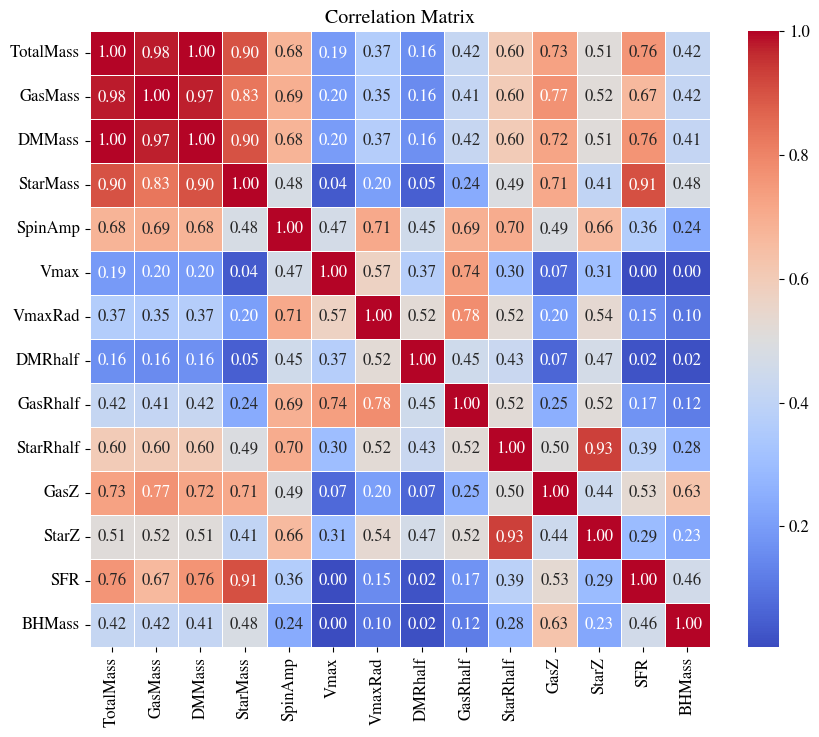

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# X 변수의 상관 행렬 계산
correlation_matrix = df.corr()

# 상관 행렬 시각화 (히트맵)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#sfr과 상관관계가 0.3 이상인 것: starmass, spinamp, vmax, dmrhalf, gasz, starz

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np

# 예시: halo_list가 3D 배열로 되어 있다고 가정
halo_list = [np.random.rand(5828203, 4)]  # 1 x 5828203 x 4 형태로 되어 있음

# halo_list를 2D 배열로 변환
halo_list_2d = np.vstack(halo_list)

# DataFrame으로 변환
data = pd.DataFrame(halo_list_2d, columns=['halospin_m', 'sfr', 'totalmass', 'starmass'])

# 결과 확인
print(data.shape)
print(data.head())

(5828203, 4)
   halospin_m       sfr  totalmass  starmass
0    0.874688  0.091302   0.062446  0.165672
1    0.729104  0.210455   0.158147  0.086728
2    0.788798  0.035614   0.630779  0.473284
3    0.091175  0.374249   0.725990  0.232277
4    0.316514  0.425551   0.876959  0.862360


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5828203 entries, 0 to 5828202
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   halospin_m  float64
 1   sfr         float64
 2   totalmass   float64
 3   starmass    float64
dtypes: float64(4)
memory usage: 177.9 MB
None
         halospin_m           sfr     totalmass      starmass
count  5.828203e+06  5.828203e+06  5.828203e+06  5.828203e+06
mean   5.002227e-01  5.001746e-01  5.001423e-01  4.995698e-01
std    2.885889e-01  2.886345e-01  2.886689e-01  2.887173e-01
min    5.274271e-08  2.985354e-07  1.511193e-07  1.387106e-07
25%    2.503851e-01  2.502936e-01  2.499802e-01  2.494280e-01
50%    5.002076e-01  5.002476e-01  5.003098e-01  4.991892e-01
75%    7.501929e-01  7.500338e-01  7.503210e-01  7.496536e-01
max    9.999999e-01  1.000000e+00  9.999999e-01  9.999998e-01


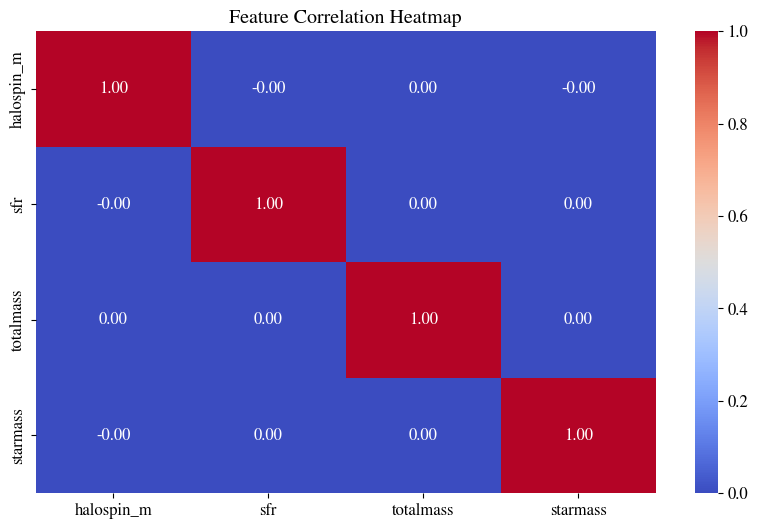

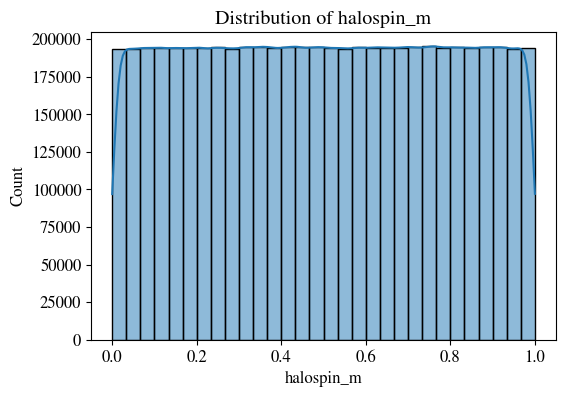

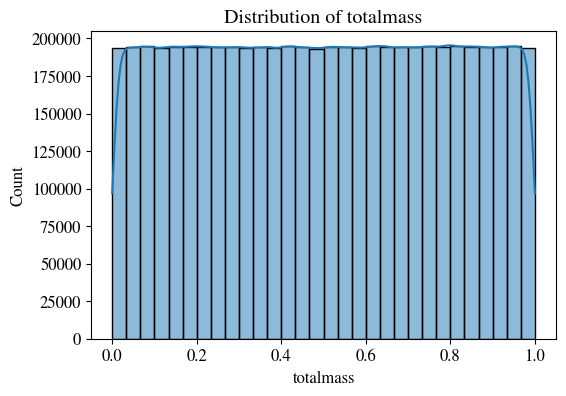

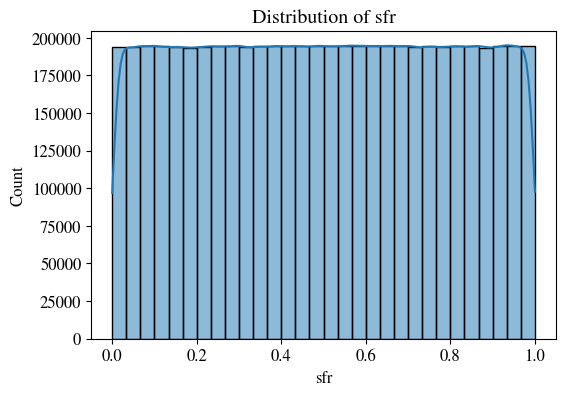

In [ ]:
# 1️. 데이터 로드 (예제 코드, 실제 데이터 경로로 수정 필요)
#data = pd.DataFrame(halo_list, columns = ['halospin_m', 'sfr', 'totalmass', 'starmass'])

# 2️. EDA (탐색적 데이터 분석)
print(data.info())  # 데이터 구조 확인
print(data.describe())  # 기초 통계량 확인

# 히트맵을 통한 상관관계 확인
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# 주요 feature들의 분포 확인
features = ['halospin_m', 'totalmass', 'sfr']
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [ ]:

# 3️. 데이터 전처리
X = data[['halospin_m', 'totalmass', 'sfr']].values  # 입력값
Y = data[['starmass']].values  # 예측값

# 데이터 스케일링
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# 데이터 분할 (학습: 80%, 검증: 20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# 4️. 딥러닝 모델 구성
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2)  # 총 질량 및 별 질량 예측 (출력 뉴런 2개)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 5. 모델 학습
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
145706/145706 ━━━━━━━━━━━━━━━━━━━━ 441s 3ms/step - loss: 1.0013 - mae: 0.8666 - val_loss: 0.9998 - val_mae: 0.8662
Epoch 2/5
145706/145706 ━━━━━━━━━━━━━━━━━━━━ 436s 3ms/step - loss: 1.0007 - mae: 0.8664 - val_loss: 0.9998 - val_mae: 0.8662
Epoch 3/5
145706/145706 ━━━━━━━━━━━━━━━━━━━━ 439s 3ms/step - loss: 1.0003 - mae: 0.8662 - val_loss: 1.0002 - val_mae: 0.8663
Epoch 4/5
145706/145706 ━━━━━━━━━━━━━━━━━━━━ 424s 3ms/step - loss: 1.0009 - mae: 0.8665 - val_loss: 1.0000 - val_mae: 0.8662
Epoch 5/5
145706/145706 ━━━━━━━━━━━━━━━━━━━━ 423s 3ms/step - loss: 1.0000 - mae: 0.8661 - val_loss: 1.0000 - val_mae: 0.8662


"\n# 6️⃣ 학습 결과 시각화\nplt.figure(figsize=(8, 4))\nplt.plot(history.history['loss'], label='Train Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.xlabel('Epochs')\nplt.ylabel('MSE Loss')\nplt.legend()\nplt.title('Model Loss Over Epochs')\nplt.show()\n\n# 7️⃣ 예측 결과 확인\nY_pred = model.predict(X_test)\nY_pred_original = scaler_Y.inverse_transform(Y_pred)  # 원래 값으로 변환\nY_test_original = scaler_Y.inverse_transform(Y_test)\n\n# 산점도로 예측 성능 확인\nplt.figure(figsize=(6, 6))\nsns.scatterplot(x=Y_test_original[:, 0], y=Y_pred_original[:, 0], label='Total Mass', alpha=0.7)\nsns.scatterplot(x=Y_test_original[:, 1], y=Y_pred_original[:, 1], label='Star Mass', alpha=0.7)\nplt.xlabel('True Values')\nplt.ylabel('Predicted Values')\nplt.plot([min(Y_test_original[:, 0]), max(Y_test_original[:, 0])], [min(Y_test_original[:, 0]), max(Y_test_original[:, 0])], 'r--')\nplt.legend()\nplt.title('Predicted vs True Galaxy Masses')\nplt.show()\n"

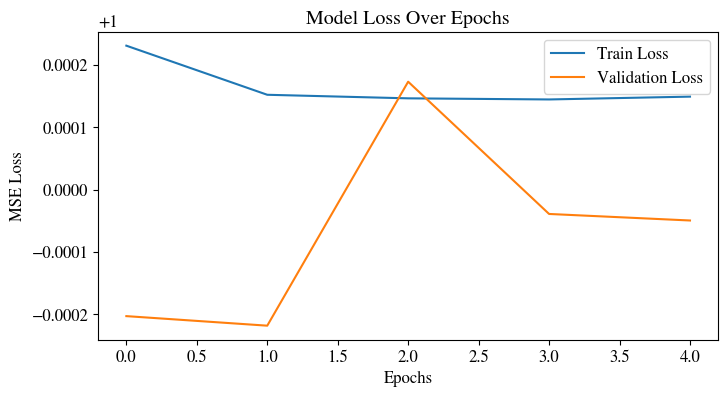

In [ ]:
# 6️. 학습 결과 시각화
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

In [ ]:
# 7️. 예측 결과 확인
Y_pred = model.predict(X_test)
Y_pred_original = scaler_Y.inverse_transform(Y_pred)  # 원래 값으로 변환
Y_test_original = scaler_Y.inverse_transform(Y_test)

In [ ]:
# 산점도로 예측 성능 확인
plt.figure(figsize=(6, 6))
sns.scatterplot(x=Y_test_original[:, 0], y=Y_pred_original[:, 0], label='Total Mass', alpha=0.7)
sns.scatterplot(x=Y_test_original[:, 1], y=Y_pred_original[:, 1], label='Star Mass', alpha=0.7)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(Y_test_original[:, 0]), max(Y_test_original[:, 0])], [min(Y_test_original[:, 0]), max(Y_test_original[:, 0])], 'r--')
plt.legend()
plt.title('Predicted vs True Galaxy Masses')
plt.show()